In [1]:
import zarr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def fourier_series(x, t, order=4) -> np.float64:
    P = 365.2421891  # siderial days per year. Same as used in https://www.sciencedirect.com/science/article/abs/pii/S0924271618300066?via%3Dihub or https://www.fs.usda.gov/nrs/pubs/jrnl/2018/nrs_2018_wilson_001.pdf
    y = x[0] + x[1]*t
    n = 1
    for i in range(2, (2*order)+2, 2):
        y = y + x[i]*np.sin(2*n*np.pi*t/P) + x[i+1]*np.cos(2*n*np.pi*t/P)
        n += 1
    return y

In [3]:
zf = zarr.open("gs://tesseract-zarr/2023/10/23/453e5e8de1ac3889994c1a4c8bca5bf0d743a28f/tensors.zarr", 'r')

In [4]:
assets = {"landsat": zf['landsat/tesseract'][:, :, 0:5, 0:5], "$0": zf['landsat/tesseract'][:, :, 0:5, 0:5]}
grids = {"landsat":{'t': zf['landsat/times'][:]}, "$0":{'t': zf['landsat/times'][:]}}

In [5]:
times = grids['landsat']['t'][:, 0].astype("datetime64[D]").astype(int)
vals = 800*(np.sin((2*np.pi/365.2421891)*times)+10)
lin = 2*times

noise = np.random.normal(scale=50, size=(len(times)))
nvals = vals + noise
nvals = nvals + lin
data = np.tile(nvals, (6,2,2,1))
data = np.moveaxis(data, -1, 0)
fake_assets = {"landsat": data, "$0": data}

In [6]:
import sys
import logging
sys.path.append('.')
from harmonic_regression import censored_lstsq, fourier_matrix, lstsq, tasseled_cap, Model

model = Model()
logger = logging.Logger(__name__)
logging.basicConfig(level=logging.INFO)
logger.setLevel(0)

/home/rob/miniconda3/envs/har-reg/lib/python3.8/site-packages/geodesic/utils/downloader.py:36: UserWarning: google.cloud.storage is installed, but GOOGLE_APPLICATION_CREDENTIALS is not set
  warnings.warn(


In [44]:
params = model.inference(assets=assets, grids=grids, logger=logger)

In [45]:
bparams = params['brightness_params'][:, :, :, :]
bparams.shape

(1, 10, 5, 5)

In [46]:
bparams[0, :, 0, 0]

array([ 1.92262696e+04,  1.58737868e+01, -1.44220461e+04,  1.74782462e+06,
        5.23181173e+05, -8.12461082e+05, -1.72025162e+06, -3.08655162e+05,
       -3.55757713e+05,  5.92909130e+05])

In [47]:
assets['landsat'][:, 0, 0, 0]

array([8219, 8019, 8215, 8030, 8152,    0, 7427,    0,    0,    0],
      dtype=uint16)

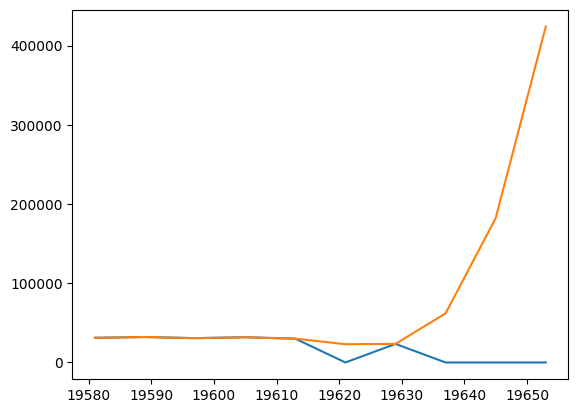

In [48]:
logging.getLogger("matplotlib").setLevel(logging.WARNING)

ls = tasseled_cap(assets['$0'])
tct_ls = ls[:, 0, 0, 0]
times = grids['$0']['t'][:,0].astype("datetime64[D]").astype(int)
pred = fourier_series(bparams[0, :, 0, 0], times)
plt.plot(times, tct_ls)
plt.plot(times, pred)

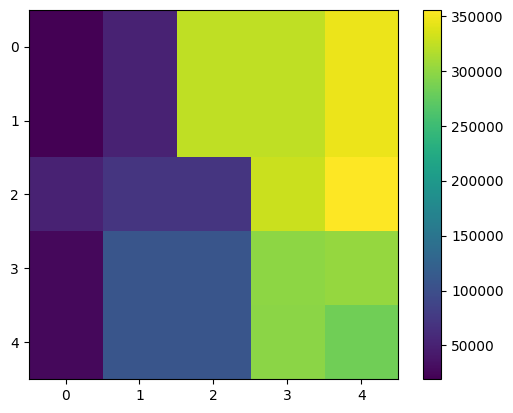

In [25]:
plt.imshow(np.moveaxis(bparams[0, [0], : , :], 0, -1))
plt.colorbar()

In [18]:
print(bparams[0, 0:3, 0, 1])
print(bparams[0, 0:3, 0, 0])

[5.10301361e+04 2.22400465e+01 3.63109317e+04]
[ 1.92262696e+04  1.58737868e+01 -1.44220461e+04]


In [17]:
np.count_nonzero(np.isnan(brightness))

0

## Try gettting params from job

In [7]:
logging.getLogger("gcsfs").setLevel(logging.WARNING)

In [21]:
brightness_job = zf['brightness-params/tesseract'][:]
wetness_job = zf['wetness-params/tesseract'][:]
greenness_job = zf['greenness-params/tesseract'][:]

In [9]:
np.count_nonzero(np.isnan(brightness_job))

8217340

In [10]:
brightness_job[0, :, 0, 0]

array([-1.03559815e+04,  2.86991302e+00,  5.93371341e+02,  1.38551950e+04,
        9.44713045e+02,  7.98544593e+03,  6.51209654e+02,  1.76295410e+03,
        3.26118906e+02, -1.35296154e+01])

In [11]:
brightness_job.shape

(1, 10, 1366, 1753)

In [12]:
zf['landsat/tesseract'].shape

(200, 6, 1366, 1753)

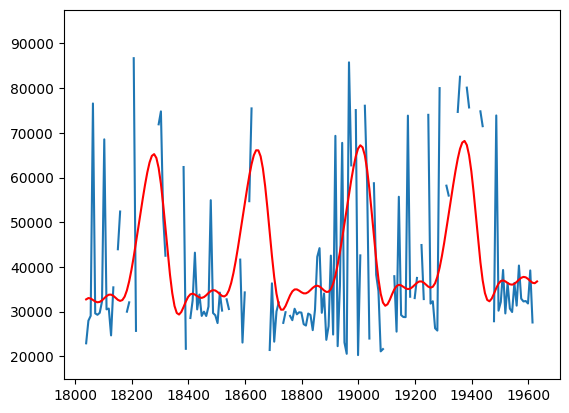

In [54]:
logging.getLogger("matplotlib").setLevel(logging.WARNING)

ls = tasseled_cap(assets['$0'])
ls[ls==0] = np.nan
tct_ls = ls[:, 0, 0, 4]
times = grids['$0']['t'][:,0].astype("datetime64[D]").astype(int)
pred = fourier_series(brightness_job[0, :, 0, 4], times)
plt.plot(times, tct_ls)
plt.plot(times, pred, color='red')

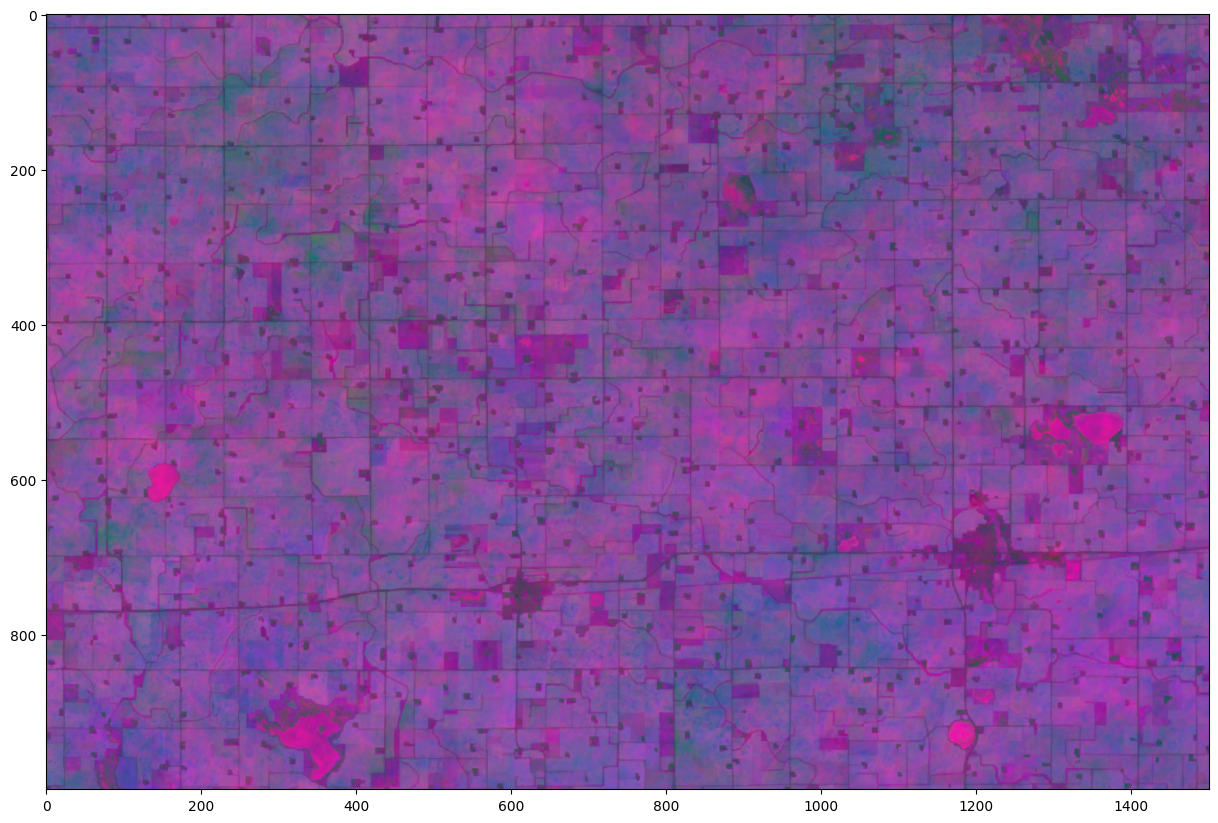

In [53]:
harmonic = 4
img_arr = np.array((brightness_job[0,harmonic,:,:], greenness_job[0, harmonic, :, :], wetness_job[0,harmonic,:,:]))[:, :1000, :1500]
img_arr = (img_arr-img_arr.min())/(img_arr.max() - img_arr.min())
fig= plt.figure(figsize=(1.5*10,1.5*15))
plt.imshow(np.moveaxis(img_arr[0:1000, 0:1500], 0, -1))

In [35]:
img_arr.min(), img_arr.max()

(-4321.364228459843, 11648.737838352765)